In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import chisquare

from collections import Counter
from utils import *


In [8]:
def missed_alleles_per_ancestry(pre,gs):
    groupscsv = "../datasets/SraRunTableD1.txt"
    groups = pd.read_csv(groupscsv)
    
    inaccurate = []
    allresult = []

    for group, df_by_group in groups.groupby('Population'):
        accession_numbers = df_by_group['Run'].values.tolist()
        gs_final = gs[gs['Run'].isin(accession_numbers)] #gs_final is a df containing the gold standard samples per population group
        gs_final = gs_final.iloc[: ,:]
        

        ret = get_inaccurate_and_all_alleles(pre,gs_final)
        inaccurate.append(ret[0])
        allresult.append(ret[1])

    yoruba_inaccurate = inaccurate[4]
    yoruba_all = allresult[4]

    europe_inaccurate = sum_euro_groups(inaccurate[1:4],True)
    europe_all = sum_euro_groups(allresult[1:4],True)

    return [yoruba_inaccurate,yoruba_all], [europe_inaccurate,europe_all]

In [9]:
data = list()
tools=["hlaforest","optitype","phlat","seq2hla","rna2hla","arcas","hlahd",'hlaminer']

yoruba_missed_alleles = []
yoruba_total_alleles = []
europe_missed_alleles = []
europe_total_alleles = []


for t in tools:
    gs=pd.read_csv("../datasets/1_gs.csv")
    pre=pd.read_csv("../results/standard/"+str(t)+"_d1.csv")
    
    for gene in ["A", "B", "C", "DQB1", "DRB1"]:
            target = gene + ".1"
            if (target not in pre.columns):
                continue
            pre[target].fillna(pre[gene], inplace=True)
        
    ret = missed_alleles_per_ancestry(pre,gs)
    
    yoruba_missed_alleles.extend(ret[0][0])
    yoruba_total_alleles.extend(ret[0][1])
    europe_missed_alleles.extend(ret[1][0])
    europe_total_alleles.extend(ret[1][1])
    



In [10]:
y_missed = Counter(yoruba_missed_alleles)
y_all = Counter(yoruba_total_alleles)

df_y = []
for k in y_all.keys():
    try:
        df_y.append([k,y_all[k],y_missed[k], (y_missed[k]/y_all[k])])
    except:
        df_y.append([k,y_all[k],0,0])
        
df_y = pd.DataFrame(df_y,columns=['allele','all','missed','percentage'])
df_y = df_y.sort_values(by=['percentage'],ascending=False)
df_y = df_y[df_y.percentage != 0] # drop all zeros... comment out if you want to keep completely accurate alleles in plot
df_y

,allele,all,missed,percentage
47,A*24:24,16,6,0.375000
46,DQB1*04:02,90,33,0.366667
50,DRB1*08:04,70,21,0.300000
17,B*53:01,160,45,0.281250
65,DRB1*14:01,35,9,0.257143
...,...,...,...,...
78,DRB1*13:27,14,1,0.071429
80,A*29:02,16,1,0.062500
53,C*15:05,16,1,0.062500
71,B*15:03,32,2,0.062500


In [11]:
e_missed = Counter(europe_missed_alleles)
e_all = Counter(europe_total_alleles)

df_e = []
for k in e_all.keys():
    try:
        df_e.append([k,e_all[k],e_missed[k], (e_missed[k]/e_all[k])])
    except:
        df_e.append([k,e_all[k],0,0])
        
df_e = pd.DataFrame(df_e,columns=['allele','all','missed','percentage'])
df_e = df_e.sort_values(by=['percentage'],ascending=False)
df_e = df_e.drop(index=[108]) # drop top row, it holds na values
df_e = df_e[df_e.percentage != 0] # drop all zeros... comment out if you want to keep completely accurate alleles in plot
df_e



,allele,all,missed,percentage
15,DRB1*16:01,56,22,0.392857
63,A*69:01,16,5,0.312500
45,DQB1*04:02,306,91,0.297386
121,DRB1*15:02,14,4,0.285714
8,DQB1*02:01,702,187,0.266382
...,...,...,...,...
14,C*07:04,96,6,0.062500
130,B*35:08,16,1,0.062500
93,DQB1*06:09,48,3,0.062500
75,DRB1*04:02,21,1,0.047619


([<matplotlib.axis.XTick at 0x7f9fc0073f10>,
 [Text(1, 0, 'yoruba'), Text(2, 0, 'europe')])

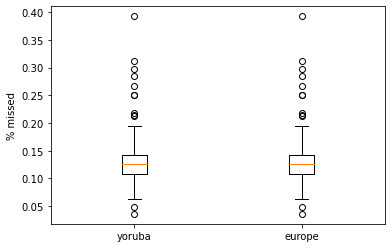

In [12]:
yoruba = df_y['percentage']
europe = yoruba = df_e['percentage']

plt.boxplot([yoruba,europe])
plt.ylabel('% missed')
plt.xticks([1,2],['yoruba','europe'])

Text(0, 0.5, '% miscall for Yoruba')

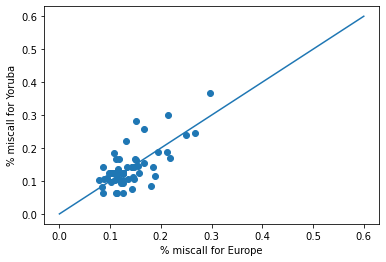

In [13]:
df = pd.merge(df_y, df_e, on='allele')

plt.scatter(df['percentage_y'],df['percentage_x'])
plt.plot(np.linspace(0, 0.6, 100),np.linspace(0, 0.6, 100))
plt.xlabel('% miscall for Europe')
plt.ylabel('% miscall for Yoruba')

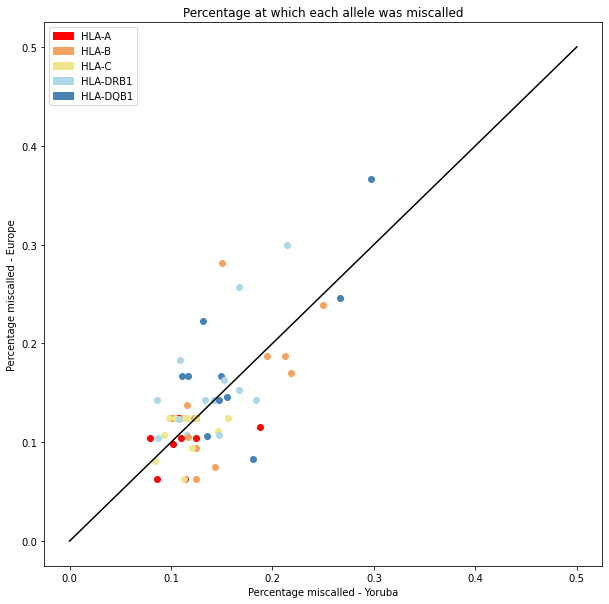

In [14]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0, 0.5, 100),np.linspace(0, 0.5, 100),color='black')


# IN THE DATAFRAME, pd.merge automatically labeled tge percentages x and y. x = yoruba, y = europe
alleles = np.array(df['allele'])
color = []

# determine what color for each bar
for a in alleles:
    if (a[0]=='A'):
        color.append('red')
    if (a[0]=='B'):
        color.append('sandybrown')
    if (a[0]=='C'):
        color.append('khaki')
    if (a[0:2]=='DR'):
        color.append('lightblue')
    if (a[0:2]=='DQ'):
        color.append('steelblue')

y = list(df['percentage_y'])
x = list(df['percentage_x'])
for i in range(len(y)):
    plt.scatter(y[i],x[i],color=color[i])
    

colors = {'HLA-A':'red', 'HLA-B':'sandybrown','HLA-C': 'khaki','HLA-DRB1':'lightblue','HLA-DQB1':'steelblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xlabel('Percentage miscalled - Yoruba')
plt.ylabel('Percentage miscalled - Europe')
plt.title('Percentage at which each allele was miscalled')

plt.legend(handles, labels)